<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula12a_transformer_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9018k      0  0:00:09  0:00:09 --:--:-- 10.2M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

In [2]:
import os, pathlib, shutil, random
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"
for category in ["pos", "neg"]:
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir / category / fname, val_dir / category / fname)

In [3]:
from tensorflow import keras
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
from tensorflow.keras.layers import TextVectorization
max_length = 600
max_tokens=20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

#Self-attention

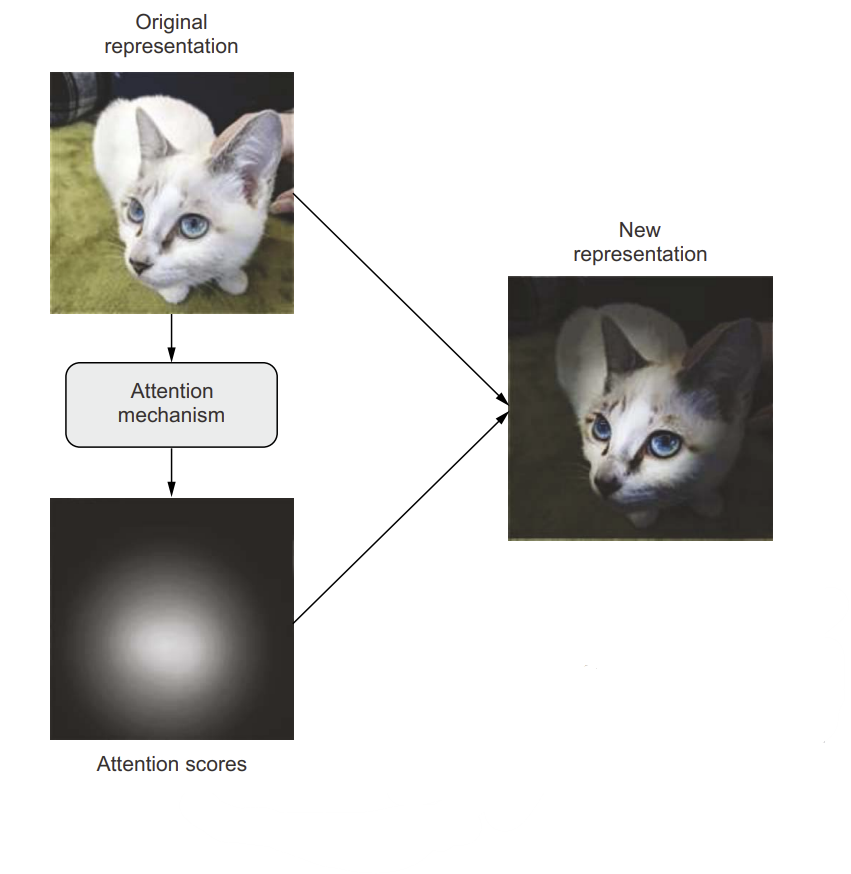

##Self-attention scores

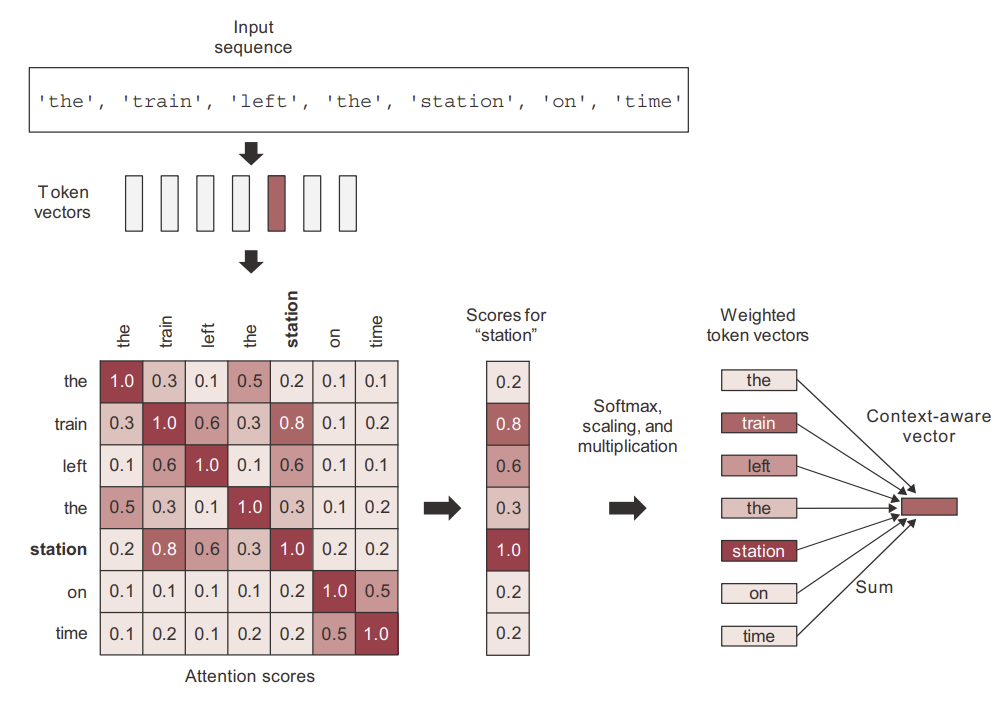

In [ ]:
from tensorflow.keras import layers
num_heads = 4
embed_dim = 256
mha_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)

##Query-key-value model

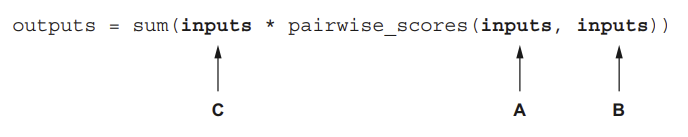

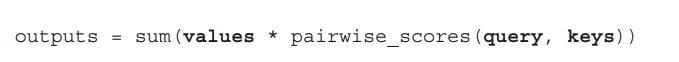

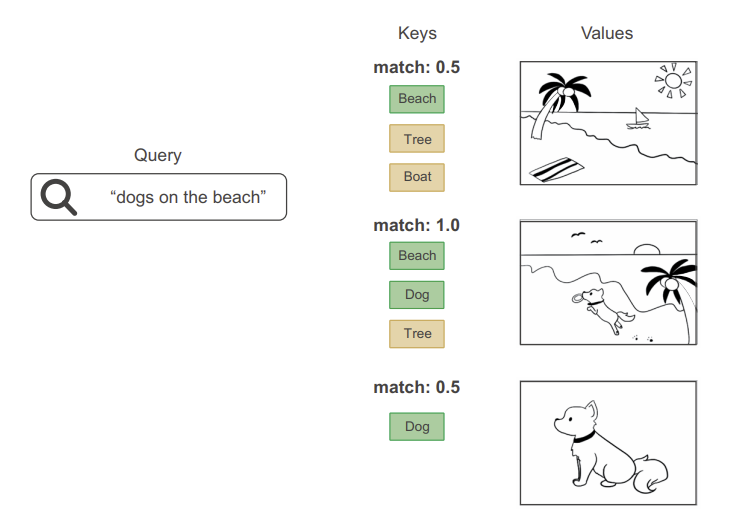

##Multi-head attention

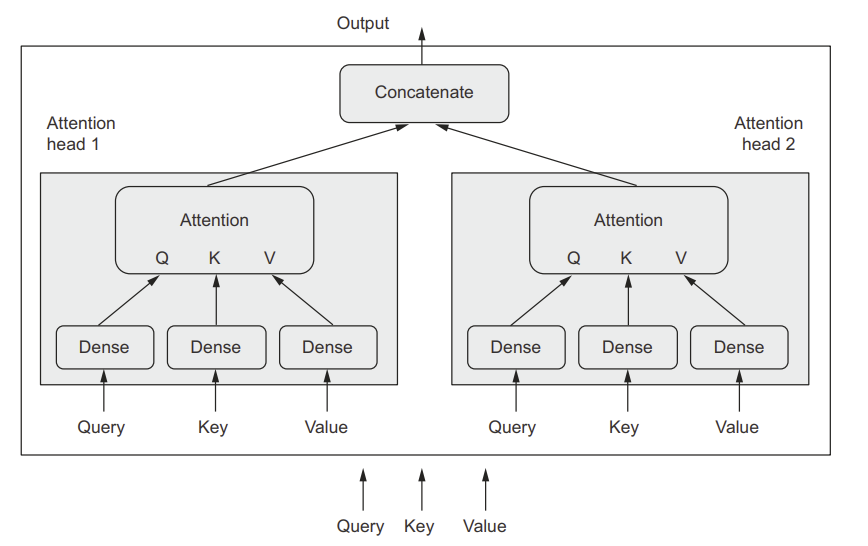

# Transformer encoder

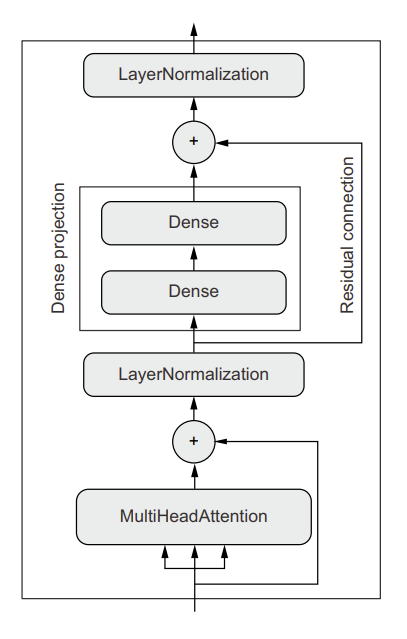

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [9]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 transformer_encoder_2 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.model.load_model("transformer_encoder.keras",
                               custom_objects={"TransformerEncoder": TransformerEncoder})
results = model.evaluate(int_test_ds)
print(results)

# Características dos modelos de NLP

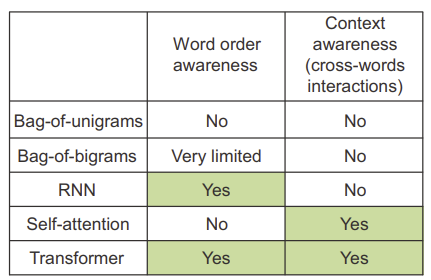

# When to use sequence models over bag-of-words models

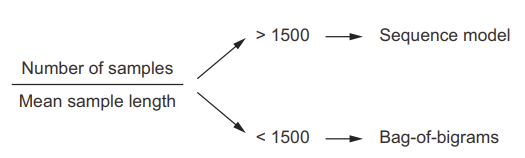